In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

2019-10-31 09:25:23,439 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-31 09:25:23,441 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:25:23,441 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [6]:
df_index = strategy.index.loc['1992':'2019-07']
df_index_return = strategy.ret.loc['1992':'2019-07']

# 2. Explore

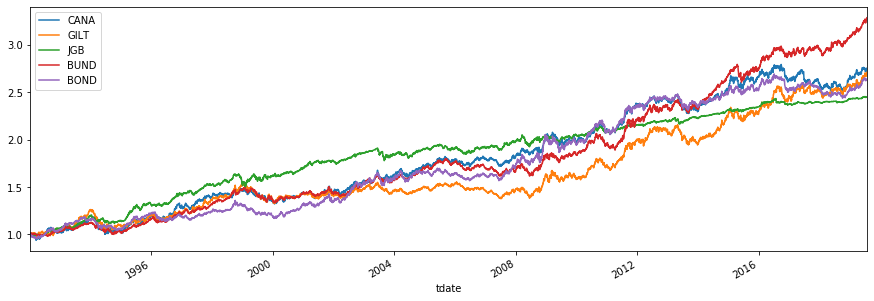

In [7]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

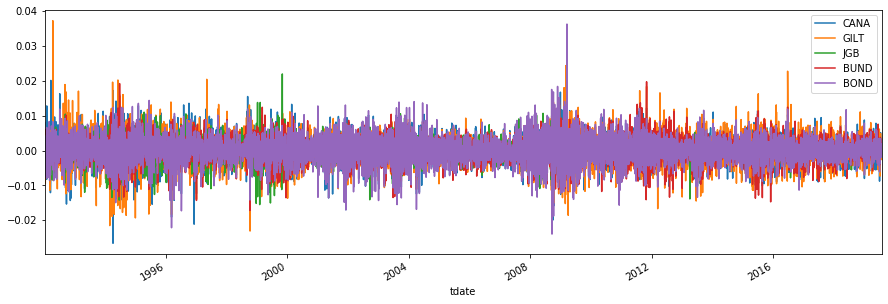

In [8]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [9]:
indiv_momentum_lst = [1, 2, 3, 4, 5, 10, 21, 42, 63]

## 1. X

### moving average 와 주가 차이

In [10]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [11]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [12]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [13]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="result/IPM_PAST.png">

<img src="result/IPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [14]:
one_week = 5
one_month = 20

In [15]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [16]:
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [17]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [18]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [19]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [20]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [21]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.672282	valid_1's binary_logloss: 0.672282
[20]	training's binary_logloss: 0.671589	valid_1's binary_logloss: 0.671589
[30]	training's binary_logloss: 0.670972	valid_1's binary_logloss: 0.670972
[40]	training's binary_logloss: 0.670421	valid_1's binary_logloss: 0.670421
[50]	training's binary_logloss: 0.669931	valid_1's binary_logloss: 0.669931
[60]	training's binary_logloss: 0.669469	valid_1's binary_logloss: 0.669469
[70]	training's binary_logloss: 0.669042	valid_1's binary_logloss: 0.669042
[80]	training's binary_logloss: 0.668636	valid_1's binary_logloss: 0.668636
[90]	training's binary_logloss: 0.668219	valid_1's binary_logloss: 0.668219
[100]	training's binary_logloss: 0.667802	valid_1's binary_logloss: 0.667802
[110]	training's binary_logloss: 0.667325	valid_1's binary_logloss: 0.667325
[120]	training's binary_logloss: 0.666866	valid_1's binary_logloss: 0.666866
[130]	training's binary

In [22]:
test_pred = model.predict(df_test_x.values)

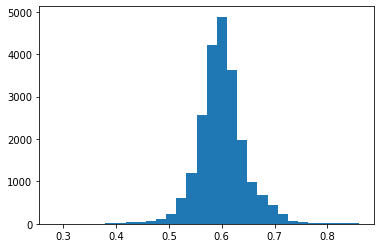

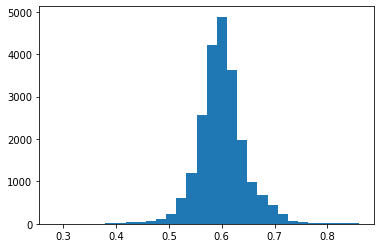

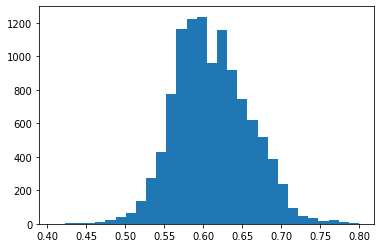

In [23]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [24]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [26]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [27]:
df_index_sub = df_index.loc['1994':]

In [28]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [29]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [30]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-31 09:25:25,611 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [31]:
tester = Tester(strategy)

In [32]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [33]:
strategy.set_portfolio_parameter(cs_strategy_type='vol')
strategy.make_portfolio()

2019-10-31 09:25:25,642 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:25:25,642 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:25:25,643 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:25:31,406 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:25:31,407 - IPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:25:33,023 - IPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 09:25:33,029 - IPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-10-31 09:25:34,077 - IPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-10-31 09:25:34,079 - IPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-10-31 09:25:34,080 - IPM - INFO - [STEP 5 - 3 - 1] TARGET VOL CONTROL to CS POSITION
2019-10-31 09:25:34,085 - IPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-10-31 09:25:40,616 - IPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITION
2019-10-31 09

### TRAIN

2019-10-31 09:25:41,855 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:25:41,856 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:25:41,864 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:25:41,870 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT


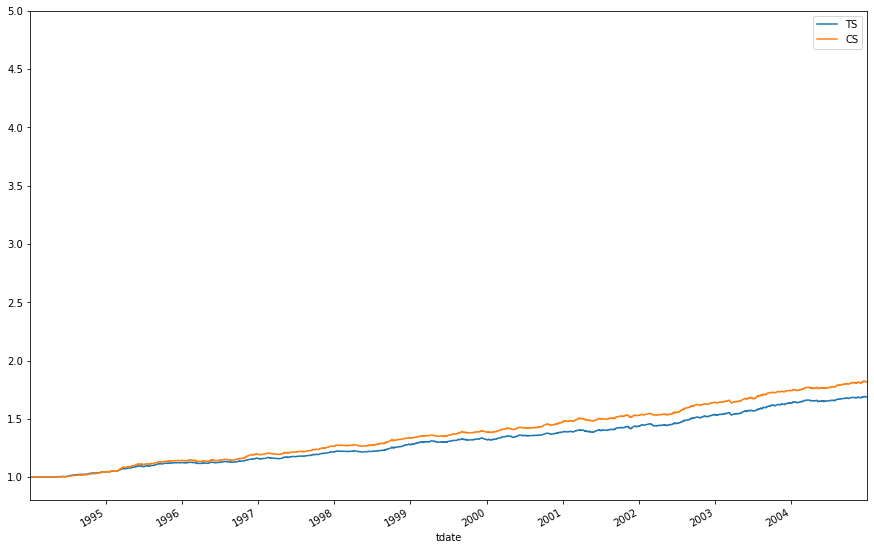

In [34]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2004-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-31 09:25:42,022 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:25:42,023 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:25:42,028 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:25:42,035 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT


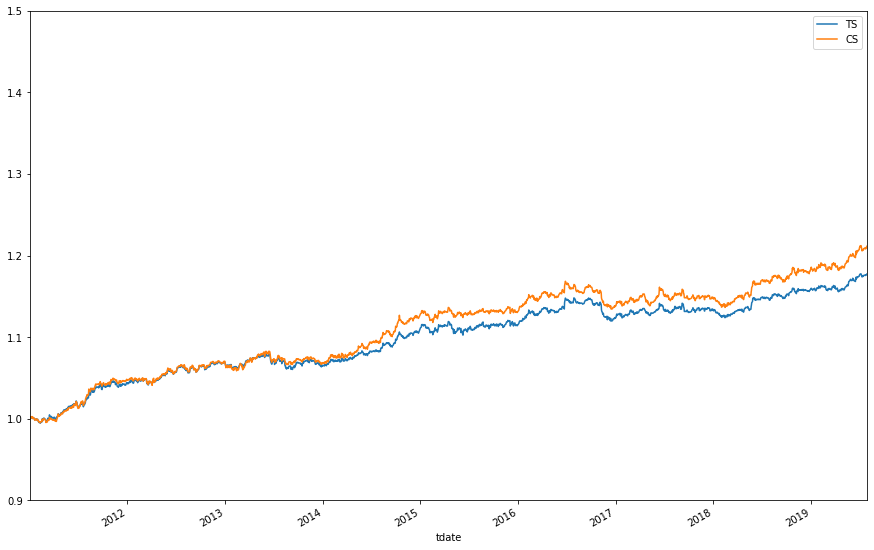

In [35]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [36]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [37]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [38]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [39]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [40]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [41]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [42]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.635016	valid_1's binary_logloss: 0.700302
[20]	training's binary_logloss: 0.633554	valid_1's binary_logloss: 0.698926
[30]	training's binary_logloss: 0.632211	valid_1's binary_logloss: 0.697736
[40]	training's binary_logloss: 0.631034	valid_1's binary_logloss: 0.69705
[50]	training's binary_logloss: 0.629931	valid_1's binary_logloss: 0.696458
[60]	training's binary_logloss: 0.628874	valid_1's binary_logloss: 0.695875
[70]	training's binary_logloss: 0.627897	valid_1's binary_logloss: 0.695499
[80]	training's binary_logloss: 0.627005	valid_1's binary_logloss: 0.694961
[90]	training's binary_logloss: 0.626115	valid_1's binary_logloss: 0.694479
[100]	training's binary_logloss: 0.625341	valid_1's binary_logloss: 0.694158
[110]	training's binary_logloss: 0.624467	valid_1's binary_logloss: 0.693868
[120]	training's binary_logloss: 0.623749	valid_1's binary_logloss: 0.693655
[130]	training's binary_

In [43]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        4.000e+00, 8.000e+00, 1.300e+01, 1.900e+01, 2.300e+01, 3.500e+01,
        4.600e+01, 3.320e+02, 4.420e+02, 5.880e+02, 9.220e+02, 1.888e+03,
        3.427e+03, 5.314e+03, 6.057e+03, 5.304e+03, 3.929e+03, 2.265e+03,
        1.256e+03, 8.230e+02, 4.040e+02, 1.290e+02, 3.700e+01, 3.000e+00]),
 array([0.16149876, 0.18613981, 0.21078086, 0.2354219 , 0.26006295,
        0.28470399, 0.30934504, 0.33398609, 0.35862713, 0.38326818,
        0.40790922, 0.43255027, 0.45719131, 0.48183236, 0.50647341,
        0.53111445, 0.5557555 , 0.58039654, 0.60503759, 0.62967864,
        0.65431968, 0.67896073, 0.70360177, 0.72824282, 0.75288386,
        0.77752491, 0.80216596, 0.826807  , 0.85144805, 0.87608909,
        0.90073014]),
 <a list of 30 Patch objects>)

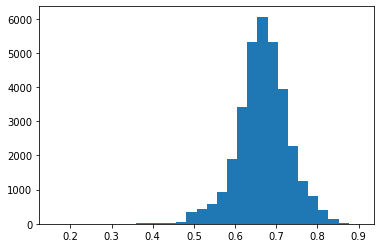

In [44]:
plt.hist(pred2, bins=30)

In [45]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [46]:
strategy2 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'

strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

2019-10-31 09:25:43,112 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-31 09:25:43,112 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-31 09:25:43,113 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:25:43,113 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:25:43,114 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:25:43,114 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [47]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='vol')
strategy2.make_portfolio()

2019-10-31 09:25:43,143 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:25:43,143 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:25:43,143 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:25:43,143 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:25:43,144 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:25:43,144 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:25:43,145 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:25:43,145 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:25:48,875 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:25:48,875 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:25:48,876 - IPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:25:48,876 - IPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 09:25:50,539 - IPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 09:25:50,539 - IPM - 

### TRAIN

2019-10-31 09:25:59,247 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:25:59,247 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:25:59,249 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:25:59,249 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:25:59,256 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:25:59,256 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:25:59,262 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:25:59,262 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT


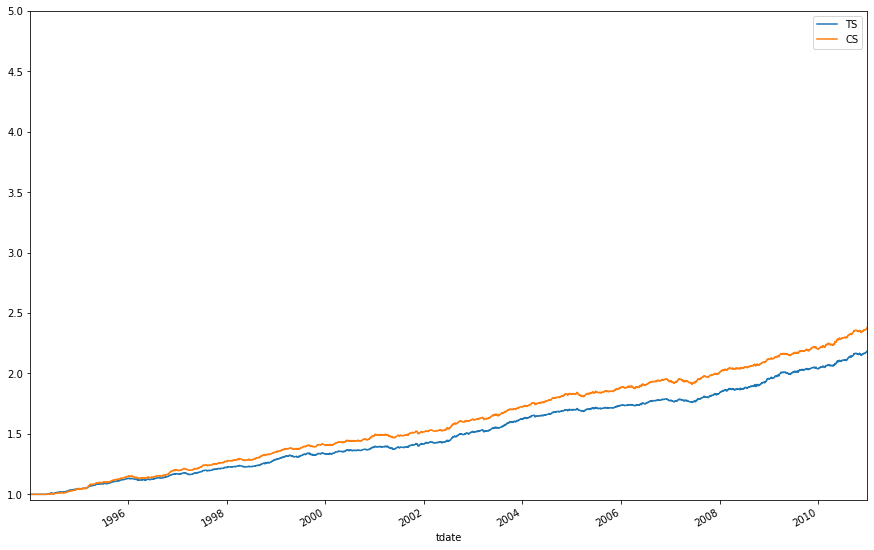

In [48]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-31 09:25:59,416 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:25:59,416 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:25:59,417 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:25:59,417 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:25:59,424 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:25:59,424 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:25:59,431 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:25:59,431 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT


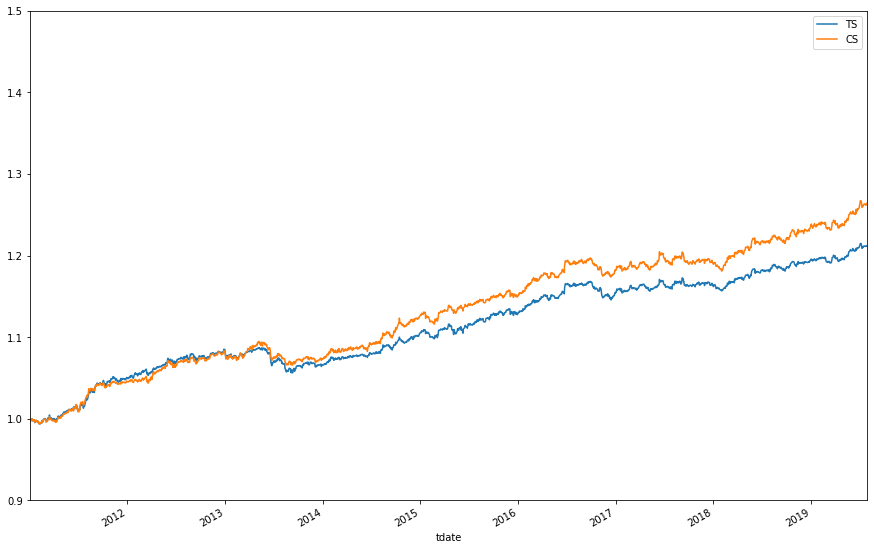

In [49]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 3. Case1을 Rolling으로 실행

In [50]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [51]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [52]:
models = []
train_preds = []
test_preds = []

In [53]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.672282	valid_1's binary_logloss: 0.67276
[20]	training's binary_logloss: 0.671589	valid_1's binary_logloss: 0.672691
[30]	training's binary_logloss: 0.670972	valid_1's binary_logloss: 0.672668
[40]	training's binary_logloss: 0.670421	valid_1's binary_logloss: 0.672687
[50]	training's binary_logloss: 0.669931	valid_1's binary_logloss: 0.672679
[60]	training's binary_logloss: 0.669469	valid_1's binary_logloss: 0.672738
[70]	training's binary_logloss: 0.669042	valid_1's binary_logloss: 0.67275
[80]	training's binary_logloss: 0.668636	valid_1's binary_logloss: 0.672807
[90]	training's binary_logloss: 0.668219	valid_1's binary_logloss: 0.673017
[100]	training's binary_logloss: 0.667802	valid_1's binary_logloss: 0.673306
[110]	training's binary_logloss: 0.667325	valid_1's binary_logloss: 0.67369
[120]	training's binary_logloss: 0.666866	valid_1's binary_logloss: 0.674099
[130]	training's binary_lo

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.672368	valid_1's binary_logloss: 0.672226
[20]	training's binary_logloss: 0.671749	valid_1's binary_logloss: 0.671486
[30]	training's binary_logloss: 0.671186	valid_1's binary_logloss: 0.670927
[40]	training's binary_logloss: 0.670681	valid_1's binary_logloss: 0.670592
[50]	training's binary_logloss: 0.67022	valid_1's binary_logloss: 0.67023
[60]	training's binary_logloss: 0.669779	valid_1's binary_logloss: 0.669825
[70]	training's binary_logloss: 0.669388	valid_1's binary_logloss: 0.669642
[80]	training's binary_logloss: 0.669036	valid_1's binary_logloss: 0.66949
[90]	training's binary_logloss: 0.668694	valid_1's binary_logloss: 0.669373
[100]	training's binary_logloss: 0.66838	valid_1's binary_logloss: 0.669264
[110]	training's binary_logloss: 0.668013	valid_1's binary_logloss: 0.669043
[120]	training's binary_logloss: 0.667636	valid_1's binary_logloss: 0.66896
[130]	training's binary_logl

[200]	training's binary_logloss: 0.66551	valid_1's binary_logloss: 0.670267
[210]	training's binary_logloss: 0.665219	valid_1's binary_logloss: 0.670087
[220]	training's binary_logloss: 0.66495	valid_1's binary_logloss: 0.669925
[230]	training's binary_logloss: 0.664699	valid_1's binary_logloss: 0.669797
[240]	training's binary_logloss: 0.664446	valid_1's binary_logloss: 0.669614
[250]	training's binary_logloss: 0.66418	valid_1's binary_logloss: 0.669242
[260]	training's binary_logloss: 0.663932	valid_1's binary_logloss: 0.668897
[270]	training's binary_logloss: 0.66368	valid_1's binary_logloss: 0.668653
[280]	training's binary_logloss: 0.66341	valid_1's binary_logloss: 0.668384
[290]	training's binary_logloss: 0.663193	valid_1's binary_logloss: 0.668152
[300]	training's binary_logloss: 0.662944	valid_1's binary_logloss: 0.667868
[310]	training's binary_logloss: 0.662717	valid_1's binary_logloss: 0.667681
[320]	training's binary_logloss: 0.662499	valid_1's binary_logloss: 0.667538
[330

[400]	training's binary_logloss: 0.661176	valid_1's binary_logloss: 0.668757
[410]	training's binary_logloss: 0.660987	valid_1's binary_logloss: 0.668772
[420]	training's binary_logloss: 0.660795	valid_1's binary_logloss: 0.668751
[430]	training's binary_logloss: 0.6606	valid_1's binary_logloss: 0.668814
[440]	training's binary_logloss: 0.660403	valid_1's binary_logloss: 0.668945
[450]	training's binary_logloss: 0.660192	valid_1's binary_logloss: 0.669024
[460]	training's binary_logloss: 0.660013	valid_1's binary_logloss: 0.669029
[470]	training's binary_logloss: 0.659819	valid_1's binary_logloss: 0.669224
[480]	training's binary_logloss: 0.65963	valid_1's binary_logloss: 0.669341
[490]	training's binary_logloss: 0.659448	valid_1's binary_logloss: 0.669398
[500]	training's binary_logloss: 0.659259	valid_1's binary_logloss: 0.669483
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.659259	valid_1's binary_logloss: 0.669483
Training until validation score

Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.672428	valid_1's binary_logloss: 0.680357
[20]	training's binary_logloss: 0.671879	valid_1's binary_logloss: 0.679907
[30]	training's binary_logloss: 0.67141	valid_1's binary_logloss: 0.679426
[40]	training's binary_logloss: 0.670991	valid_1's binary_logloss: 0.679171
[50]	training's binary_logloss: 0.670602	valid_1's binary_logloss: 0.678954
[60]	training's binary_logloss: 0.67023	valid_1's binary_logloss: 0.678652
[70]	training's binary_logloss: 0.669898	valid_1's binary_logloss: 0.678404
[80]	training's binary_logloss: 0.669575	valid_1's binary_logloss: 0.678128
[90]	training's binary_logloss: 0.669258	valid_1's binary_logloss: 0.678035
[100]	training's binary_logloss: 0.668952	valid_1's binary_logloss: 0.67798
[110]	training's binary_logloss: 0.668658	valid_1's binary_logloss: 0.678001
[120]	training's binary_logloss: 0.668333	valid_1's binary_logloss: 0.677864
[130]	training's binary_lo

In [54]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([8.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 5.000e+00, 4.000e+00,
        1.300e+01, 3.000e+01, 5.700e+01, 6.800e+01, 1.410e+02, 3.540e+02,
        9.870e+02, 1.853e+03, 1.445e+03, 1.403e+03, 1.277e+03, 1.139e+03,
        7.370e+02, 6.100e+02, 4.920e+02, 2.200e+02, 1.270e+02, 5.200e+01,
        3.600e+01, 5.100e+01, 1.900e+01, 1.200e+01, 1.000e+01, 4.000e+00]),
 array([0.34141927, 0.35809023, 0.3747612 , 0.39143216, 0.40810312,
        0.42477409, 0.44144505, 0.45811602, 0.47478698, 0.49145795,
        0.50812891, 0.52479987, 0.54147084, 0.5581418 , 0.57481277,
        0.59148373, 0.6081547 , 0.62482566, 0.64149662, 0.65816759,
        0.67483855, 0.69150952, 0.70818048, 0.72485144, 0.74152241,
        0.75819337, 0.77486434, 0.7915353 , 0.80820627, 0.82487723,
        0.84154819]),
 <a list of 30 Patch objects>)

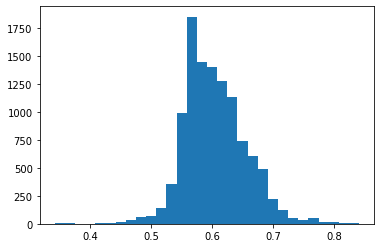

In [55]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [56]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [57]:
strategy3 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'

strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-10-31 09:26:05,559 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-31 09:26:05,559 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-31 09:26:05,559 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-31 09:26:05,561 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:26:05,561 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:26:05,561 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:26:05,562 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:26:05,562 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:26:05,562 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [58]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='vol')
strategy3.make_portfolio()

2019-10-31 09:26:05,595 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:26:05,595 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:26:05,595 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:26:05,596 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:26:05,596 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:26:05,596 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:26:05,598 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:26:05,598 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:26:05,598 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:26:05,599 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:26:05,599 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:26:05,599 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:26:11,263 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:26:11,263 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:26:11,263 - IPM -

2019-10-31 09:26:14,735 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:26:14,735 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:26:14,735 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:26:14,736 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:26:14,736 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:26:14,736 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:26:14,743 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:26:14,743 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:26:14,743 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:26:14,751 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:26:14,751 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:26:14,751 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT


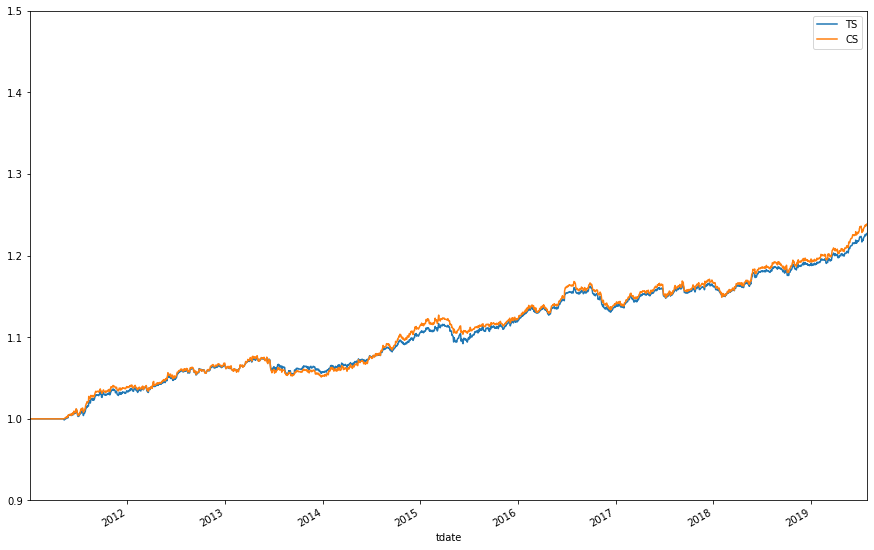

In [59]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 4. CASE 2를 ROLLING으로 실행

In [60]:
models = []
train_preds = []
test_preds = []

In [61]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.635016	valid_1's binary_logloss: 0.682075
[20]	training's binary_logloss: 0.633554	valid_1's binary_logloss: 0.681582
[30]	training's binary_logloss: 0.632211	valid_1's binary_logloss: 0.680971
[40]	training's binary_logloss: 0.631034	valid_1's binary_logloss: 0.68045
[50]	training's binary_logloss: 0.629931	valid_1's binary_logloss: 0.680069
[60]	training's binary_logloss: 0.628874	valid_1's binary_logloss: 0.679956
[70]	training's binary_logloss: 0.627897	valid_1's binary_logloss: 0.679865
[80]	training's binary_logloss: 0.627005	valid_1's binary_logloss: 0.679699
[90]	training's binary_logloss: 0.626115	valid_1's binary_logloss: 0.679391
[100]	training's binary_logloss: 0.625341	valid_1's binary_logloss: 0.679319
[110]	training's binary_logloss: 0.624467	valid_1's binary_logloss: 0.679278
[120]	training's binary_logloss: 0.623749	valid_1's binary_logloss: 0.679166
[130]	training's binary_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[80]	training's binary_logloss: 0.627712	valid_1's binary_logloss: 0.678167
[90]	training's binary_logloss: 0.626951	valid_1's binary_logloss: 0.677942
[100]	training's binary_logloss: 0.626317	valid_1's binary_logloss: 0.677941
[110]	training's binary_logloss: 0.625611	valid_1's binary_logloss: 0.677917
[120]	training's binary_logloss: 0.624965	valid_1's binary_logloss: 0.677908
[130]	training's binary_logloss: 0.624337	valid_1's binary_logloss: 0.677839
[140]	training's binary_logloss: 0.623737	valid_1's binary_logloss: 0.677809
[150]	training's binary_logloss: 0.623125	valid_1's binary_logloss: 0.67771
[160]	training's binary_logloss: 0.62242	valid_1's binary_logloss: 0.677585
[170]	training's binary_logloss: 0.621721	valid_1's binary_logloss: 0.677569
[180]	training's binary_logloss: 0.621082	valid_1's binary_logloss: 0.677677
[190]	training's binary_logloss: 0.620482	valid_1's binary_logloss: 0.677749
[200]	training's binary_logloss: 0.619909	valid_1's binary_logloss: 0.677617
[21

[280]	training's binary_logloss: 0.617267	valid_1's binary_logloss: 0.684412
[290]	training's binary_logloss: 0.616878	valid_1's binary_logloss: 0.684776
[300]	training's binary_logloss: 0.61654	valid_1's binary_logloss: 0.685193
[310]	training's binary_logloss: 0.616156	valid_1's binary_logloss: 0.685371
[320]	training's binary_logloss: 0.615833	valid_1's binary_logloss: 0.685813
[330]	training's binary_logloss: 0.615451	valid_1's binary_logloss: 0.686331
[340]	training's binary_logloss: 0.615037	valid_1's binary_logloss: 0.686813
[350]	training's binary_logloss: 0.614685	valid_1's binary_logloss: 0.687113
[360]	training's binary_logloss: 0.614355	valid_1's binary_logloss: 0.687367
[370]	training's binary_logloss: 0.613967	valid_1's binary_logloss: 0.688152
[380]	training's binary_logloss: 0.613607	valid_1's binary_logloss: 0.689045
[390]	training's binary_logloss: 0.613232	valid_1's binary_logloss: 0.689577
[400]	training's binary_logloss: 0.612861	valid_1's binary_logloss: 0.690093


[450]	training's binary_logloss: 0.609111	valid_1's binary_logloss: 0.701556
[460]	training's binary_logloss: 0.608781	valid_1's binary_logloss: 0.70245
[470]	training's binary_logloss: 0.608433	valid_1's binary_logloss: 0.702766
[480]	training's binary_logloss: 0.608119	valid_1's binary_logloss: 0.70406
[490]	training's binary_logloss: 0.60779	valid_1's binary_logloss: 0.703488
[500]	training's binary_logloss: 0.607498	valid_1's binary_logloss: 0.704096
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.607498	valid_1's binary_logloss: 0.704096
Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.635045	valid_1's binary_logloss: 0.682283
[20]	training's binary_logloss: 0.63346	valid_1's binary_logloss: 0.681698
[30]	training's binary_logloss: 0.63207	valid_1's binary_logloss: 0.681477
[40]	training's binary_logloss: 0.630819	valid_1's binary_logloss: 0.681118
[50]	training's binary_logloss: 0.629669	valid_1's b

[20]	training's binary_logloss: 0.633729	valid_1's binary_logloss: 0.695686
[30]	training's binary_logloss: 0.632476	valid_1's binary_logloss: 0.695071
[40]	training's binary_logloss: 0.631333	valid_1's binary_logloss: 0.694552
[50]	training's binary_logloss: 0.630206	valid_1's binary_logloss: 0.694263
[60]	training's binary_logloss: 0.629138	valid_1's binary_logloss: 0.694355
[70]	training's binary_logloss: 0.62821	valid_1's binary_logloss: 0.694101
[80]	training's binary_logloss: 0.627306	valid_1's binary_logloss: 0.693781
[90]	training's binary_logloss: 0.626458	valid_1's binary_logloss: 0.693578
[100]	training's binary_logloss: 0.625727	valid_1's binary_logloss: 0.693498
[110]	training's binary_logloss: 0.624989	valid_1's binary_logloss: 0.693688
[120]	training's binary_logloss: 0.624391	valid_1's binary_logloss: 0.692684
[130]	training's binary_logloss: 0.623762	valid_1's binary_logloss: 0.691737
[140]	training's binary_logloss: 0.623123	valid_1's binary_logloss: 0.691501
[150]	tr

In [62]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [63]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [64]:
strategy4 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'

strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-10-31 09:26:19,789 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-31 09:26:19,789 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-31 09:26:19,789 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-31 09:26:19,789 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-31 09:26:19,792 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:26:19,792 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:26:19,792 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:26:19,792 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:26:19,793 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:26:19,793 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:26:19,793 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:26:19,793 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [65]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='vol')
strategy4.make_portfolio()

2019-10-31 09:26:19,834 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:26:19,834 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:26:19,834 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:26:19,834 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:26:19,836 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:26:19,836 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:26:19,836 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:26:19,836 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:26:19,837 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:26:19,837 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:26:19,837 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:26:19,837 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:26:19,838 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:26:19,838 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:26:19,838 - IPM - INFO -

2019-10-31 09:26:29,034 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:26:29,034 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:26:29,034 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:26:29,034 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:26:29,036 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:26:29,036 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:26:29,036 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:26:29,036 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-31 09:26:29,043 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:26:29,043 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:26:29,043 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:26:29,043 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-31 09:26:29,050 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:26:29,050 - IPM - INFO - [STEP 7]

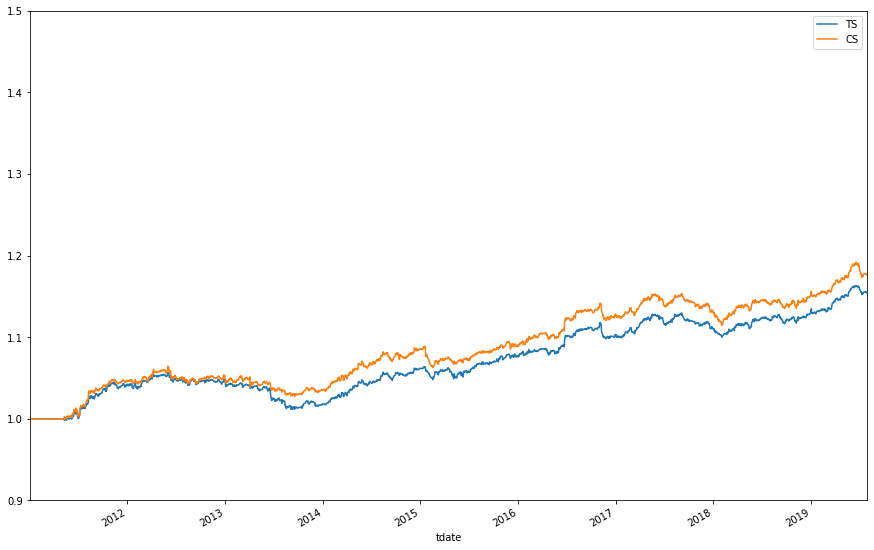

In [66]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))